 # Gold Nanoparticles Circular Magnetic Dichroism Example (CMD)
 In this notebook we calculate the MCD signal for gold nanoparticles following two different approaches. The first is a scalar approache, as in:
 
 Pineider, F.; Campo, G.; Bonanni, V.; Fernández, C. de J.; Mattei, G.; Caneschi, A.; Gatteschi, D.; Sangregorio, C. **Circular Magnetoplasmonic Modes in Gold Nanoparticles.** *Nano Lett.* 2013, 13, 4785–4789.
 
 the second is the full tensorial Transfer Matrix approach, as in:
 
 Maccaferri, N.; González-Díaz, J. B.; Bonetti, S.; Berger, A.; Kataja, M.; van Dijken, S.; Nogués, J.; Bonanni, V.; Pirzadeh, Z.; Dmitriev, A.; et al. **Polarizability and Magnetoplasmonic Properties of Magnetic General Nanoellipsoids.** *Opt. Express* 2013, 21, 9875–9889.
 
 The notebook is structured as follows:
 -  Setup of useful settings and import of necessary libraries
 -  Setup of scalar MCD functions
 -  Inputs for the simulation
 -  Computation
 - Plot


## Settings and libraries

In [1]:
# libraries
import numpy as np # numpy
import scipy as sp # scipy
import scipy.constants as sp_c # scientific constants
import sys  # sys to add py_matrix to the path

# matplotlib inline plots
import matplotlib.pylab as plt
%matplotlib inline

# adding py_matrix parent folder to python path
sys.path.append('../../')
import py_matrix as pm # importing py_matrix

# useful parameters
f_size=20;
h_bar=sp_c.hbar/sp_c.eV # h_bar in eV

## MCD functions as found in :
Pineider, F.; Campo, G.; Bonanni, V.; Fernández, C. de J.; Mattei, G.; Caneschi, A.; Gatteschi, D.; Sangregorio, C. **Circular Magnetoplasmonic Modes in Gold Nanoparticles.** *Nano Lett.* 2013, 13, 4785–4789.
We are going to compare our t-matrix calculations with the ones contained in the above paper, where the approach is simply to calculate a modified polarizability for *left* and *right* circularly polarized lighe taking into account the effect of the **B** field as a Lorentz force. All the functions defined below are found in the paper and in the Supporting Informations


In [2]:
# size corrected damping constant for plasma oscillation
def gamma_r(gamma_inf,v_f,r):
    return gamma_inf + h_bar*v_f/(r*1e-9)

# coupling function to external magnetic field
def f_w(wl,w_p,gamma):
    w=1240/wl # nm to eV
    f_out=-h_bar*(sp_c.e/sp_c.m_e)*(w_p**2/w)*((gamma-1j*w)*(gamma-1j*w))/((gamma**2+w**2)**2)
    return f_out

# magnetic field dependent polarizability
def alpha_mattei(wl,eps,eps_m,f_w,f_m,D,B):
    norm=-np.pi*(D**3)/2.0
    num=eps-eps_m+(f_w-f_m)*B
    den=eps+2.0*eps_m+(f_w-f_m)*B
    alpha=norm*num/den
    return alpha

# scattering cross section
def sigma_mattei(wl,eps_m,alpha):
    return (2.0*np.pi/wl)*np.sqrt(eps_m)*np.imag(alpha)

## Inputs

In [3]:
# building the optical constant database, point the folder below to the "materials" py_matrix folder
eps_db_out=pm.mat.generate_eps_db('../materials/',ext='*.edb')
eps_files,eps_names,eps_db=eps_db_out['eps_files'],eps_db_out['eps_names'],eps_db_out['eps_db']

In [4]:
# multilayer and computation inputs
D=13.0; # nanocluster diameter
f=0.01; # filling factor for the effective medium containing the Au nanoclusters
stack=['e_hexane','e_au','e_hexane'] # materials composing the stack, as taken from eps_db
d_list=[0.0,D,0.0] # multilayer thicknesses: incident medium and substrate have zero thickness

# wavelength
wl_min=400 
wl_max=800
wl_step=100;
v_wl=np.linspace(wl_min,wl_max,wl_step);

# polar and azimuthal angles in radians
theta_0=0.0
phi_0=0.0

# drude metal parameters
w_p=8.95 # plasma frequency
gamma=0.02 # damping constant
f_m=1.06e-6 # medium magnetic coupling
v_f=1.4e6; # Fermi velocity
gamma_inf=0.069; # bulk damping constant

# B field in Tesla
B=1.0

## Scalar MCD calculations following Nano Lett. 2013, 13, 4785–4789

In [5]:
# Scalar MCD calculations following Nano Lett. 2013, 13, 4785–4789
v_sigma_plus=np.zeros_like(v_wl)
v_sigma_minus=np.zeros_like(v_wl)
v_sigma_zero=np.zeros_like(v_wl)
for i_wl,wl in enumerate(v_wl):
    
    # Magnetic field corrections
    gamma_r0=gamma_r(gamma_inf,v_f,D/2)
    f_w0=f_w(wl,w_p,gamma_r0)
    
    # optical constants
    eps=pm.mat.db_to_eps(wl,eps_db,['e_au'])[0];
    e_corr=pm.mat.eps_corr_drude(wl,w_p,gamma_inf,v_f,D/2) # mean free path correction
    eps=eps+e_corr;
    eps=np.real(eps)-1j*np.imag(eps); # flipping imaginary part size due to different conventions
    eps_m=np.real(pm.mat.db_to_eps(wl,eps_db,['e_hexane'])[0])
    
    # polarizability and 
    alpha=alpha_mattei(wl,eps,eps_m,f_w0,f_m,D,B);v_sigma_plus[i_wl]=sigma_mattei(wl,eps_m,alpha) # Left pol
    alpha=alpha_mattei(wl,eps,eps_m,f_w0,f_m,D,-B);v_sigma_minus[i_wl]=sigma_mattei(wl,eps_m,alpha) # Right pol
    alpha=alpha_mattei(wl,eps,eps_m,f_w0,f_m,D,0.0);v_sigma_zero[i_wl]=sigma_mattei(wl,eps_m,alpha) # B=0
    
v_mcd=(v_sigma_minus-v_sigma_plus)/v_sigma_zero.max()

## Full Transfer Matrix Calculations
The Maxwell-Garnett effective medium for the layer containing the gold nanoclusters is calculating following: Maccaferri, N.; González-Díaz, J. B.; Bonetti, S.; Berger, A.; Kataja, M.; van Dijken, S.; Nogués, J.; Bonanni, V.; Pirzadeh, Z.; Dmitriev, A.; et al. **Polarizability and Magnetoplasmonic Properties of Magnetic General Nanoellipsoids.** *Opt. Express* 2013, 21, 9875–9889.
 

In [6]:
# polarization correction factors for gold nanoclusters
a_x=D/2;a_y=D/2;a_z=D/2;
m_L=pm.moe.m_L(a_x,a_y,a_z);
m_D=pm.moe.m_D(a_x,a_y,a_z);
V=pm.moe.f_V(a_x,a_y,a_z)

In [7]:
# Full transfer matrix calculations
v_A_r=np.zeros_like(v_wl);v_A_l=np.zeros_like(v_wl);
v_A_p=np.zeros_like(v_wl);v_A_s=np.zeros_like(v_wl);
m_eps=np.zeros((len(stack),3,3),dtype=np.complex128)
for i_wl,wl in enumerate(v_wl):
    
    # retrieving optical constants at wl from the database
    e_list=pm.mat.db_to_eps(wl,eps_db,stack);
    e_corr=pm.mat.eps_corr_drude(wl,w_p,gamma_inf,v_f,D/2)
    #print e_corr
    e_list[1]=e_list[1]+e_corr
    e_xy=pm.mat.eps_xy_drude(wl, w_p, gamma_r0, B)    
    
    # calculating the MG effective medium
    em=e_list[0]
    m_e1=np.identity(3)*em;
    m_e2=np.identity(3)*e_list[1];
    m_e2[1,0]=e_xy;m_e2[0,1]=-e_xy;
    m_eff=pm.mat.m_eff_MG(m_L,m_D,V,m_e1,m_e2,wl,f)
    
    # filling dielectric tensor
    m_eps[:,0,0]=e_list
    m_eps[:,1,1]=e_list
    m_eps[:,2,2]=e_list
    m_eps[1,:,:]=m_eff
    
    # computing transmission matrix
    m_t_ps=pm.core.rt(wl,theta_0,phi_0,m_eps,d_list)['m_t_ps']
    
    # extracting the mcd information from the transmission matrix
    n_0=np.sqrt(e_list[0]);n_s=np.sqrt(e_list[-1]);
    out=pm.utils.T_ps_rl(m_t_ps,theta_0,n_0,n_s)
    v_A_r[i_wl]=out['A_r']
    v_A_l[i_wl]=out['A_l']
    v_A_p[i_wl]=out['A_p']
    v_A_s[i_wl]=out['A_s']
    

## Plot

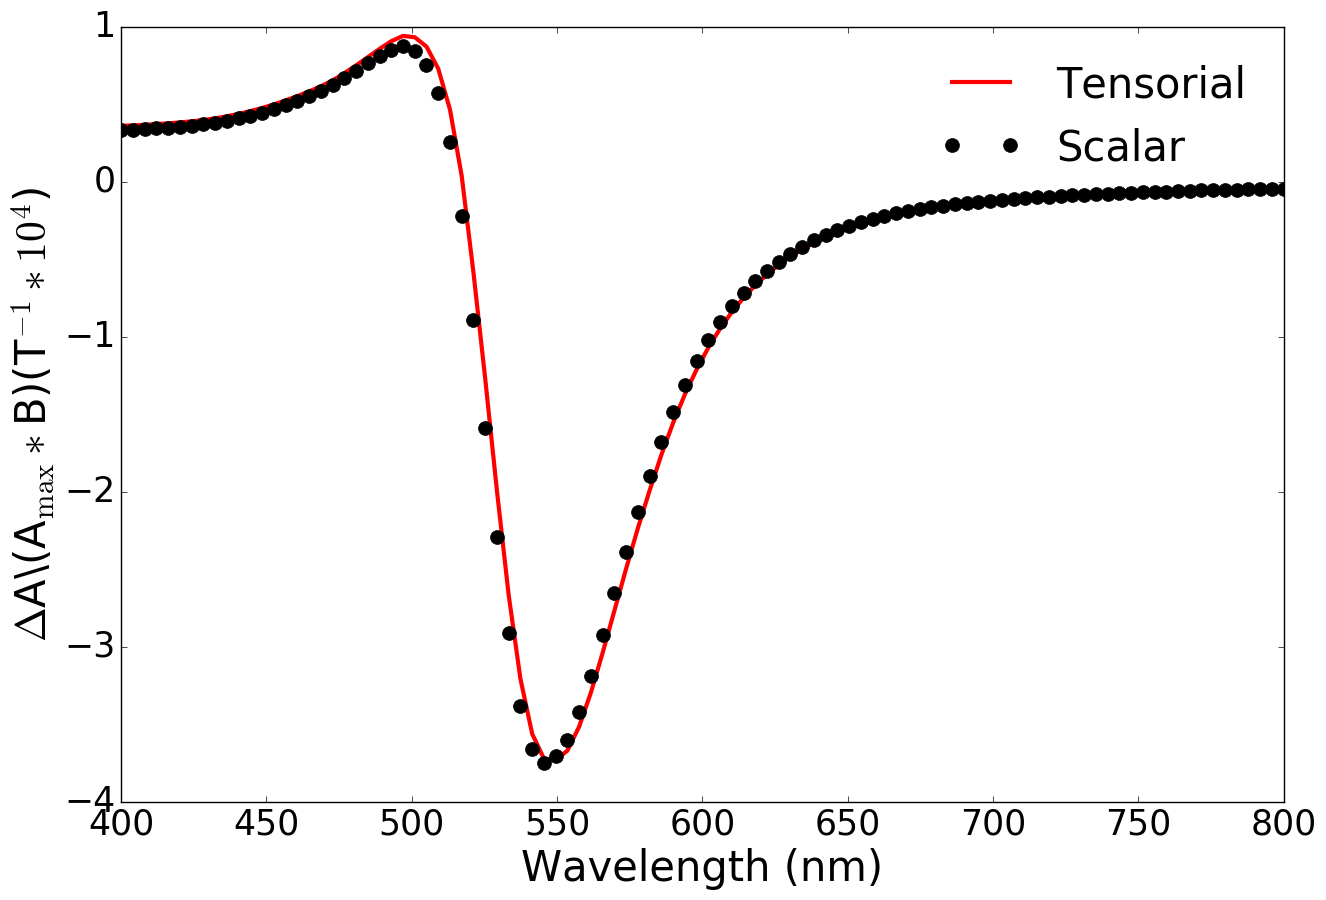

In [8]:
# cmd plot
fg2=plt.figure(num=2,figsize=(15,10))
plt.plot(v_wl,1e4*(v_A_r-v_A_l)/(v_A_r).max(),'r-',
         v_wl,1e4*v_mcd,'ko',
         markersize=10,linewidth=3);

#-----ticks------
fsize=15;
plt.xticks(fontsize=fsize+10);plt.yticks(fontsize=fsize+10);

#------axis labels------
plt.xlabel(r'Wavelength (nm)',fontsize=fsize+15);
plt.ylabel(r'$\Delta$A\(A$_{\mathrm{max}}*$B)(T$^{-1}*10^{4}$)',fontsize=fsize+15);

#------plot legend------
plt.legend(('Tensorial','Scalar'), fontsize=fsize+15,loc='upper right',frameon=False);